In [24]:
# ─── Chunk 1: Imports and File Paths ───────────────────────────────────────────
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Adjust these paths if your CSVs live elsewhere
path_ph6 = "Patient1_Hippo_6.csv"
path_ph4 = "Patient1_Hippo_4f.csv"


In [25]:
# ─── Chunk 2: Load CSVs and Assign Labels ──────────────────────────────────────
# Read each file into a DataFrame
df4 = pd.read_csv(path_ph4)
#df6 = pd.read_csv(path_ph6)

# Create a “label” column: 4 for PH_4 trials, 6 for PH_6
#df4['label'] = 4
#df6['label'] = 6

# Concatenate into one DataFrame for modeling
df=df4
#df = pd.concat([df4, df6], ignore_index=True)
#print(f"Total trials loaded: {len(df)}")


In [26]:
# ─── Chunk 3: Parse Firing‐Rate Lists ───────────────────────────────────────────
# Identify all columns beginning with 'FR_neuron'
fr_cols = [c for c in df.columns if c.startswith('FR_neuron')]

# Each of these columns currently holds a string like "[12.5, 20.0, …]"
# Convert each string into an actual Python list
for col in fr_cols:
    df[col] = df[col].apply(ast.literal_eval)

# Quick sanity check
print(df[fr_cols].iloc[0])


FR_neuron2[AHL2]                             [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neuron3[AHL2]     [0.0, 0.0, 11.111111111111128, 0.0, 11.1111111...
FR_neuron4[AHL2]               [0.0, 0.0, 5.555555555555564, 0.0, 0.0]
FR_neuron5[AHL2]                             [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neuron6[AHL2]               [0.0, 0.0, 5.555555555555564, 0.0, 0.0]
FR_neuron7[AHL2]                             [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neuron8[AHL2]                             [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neuron9[AHL2]                             [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neuron10[AHL5]    [0.0, 0.0, 5.555555555555564, 5.55555555555556...
FR_neuron11[AHL5]              [0.0, 0.0, 0.0, 5.555555555555564, 0.0]
FR_neuron12[AHL5]                            [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neuron13[AHL5]              [0.0, 0.0, 5.555555555555564, 0.0, 0.0]
FR_neuron14[AHL7]                            [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neuron15[AHL7]                            [0.0, 0.0, 0.0, 0.0, 0.0]
FR_neu

In [27]:
# ─── Chunk 4: Expand Each Bin into Its Own Feature ────────────────────────────
expanded_dfs = []
for col in fr_cols:
    # Determine how many bins (should be 12)
    n_bins = len(df[col].iloc[0])
    # Generate column names: e.g. FR_neuron32_bin0 … FR_neuron32_bin11
    bin_names = [f"{col}_bin{i}" for i in range(n_bins)]
    # Expand the list‐of‐bins into a DataFrame
    bins_df = pd.DataFrame(df[col].tolist(), columns=bin_names)
    expanded_dfs.append(bins_df)

# Concatenate all neurons’ bins side by side
X = pd.concat(expanded_dfs, axis=1)
y = df['acc_bin']

print("Feature matrix shape:", X.shape)

Feature matrix shape: (47, 105)


In [38]:
from sklearn.utils import resample

# X : (47, n_features) feature matrix  
# y : (47,) label vector

# draw 200 samples with replacement
X_resampled, y_resampled = resample(
    X, y,
    replace=True,      # sample with replacement
    n_samples=200,     # how many total samples you want
    random_state=0
)

print("Resampled shapes:", X_resampled.shape, y_resampled.shape)

Resampled shapes: (200, 105) (200,)


In [23]:
neuron_cols = [c for c in df.columns if c.startswith('FR_neuron')]
n_bins = len(df[neuron_cols[0]].iloc[0])
assert all(df[col].map(len).eq(n_bins).all() for col in neuron_cols), \
    "Not every neuron column has the same bin count!"

AssertionError: Not every neuron column has the same bin count!

In [42]:
y_resampled

44    1
0     0
3     0
3     0
39    1
     ..
15    0
11    0
38    0
29    1
1     1
Name: acc_bin, Length: 200, dtype: int64

In [47]:
# ─── Chunk 5: Train/Test Split ─────────────────────────────────────────────────
# Use an 80/20 stratified split to preserve label proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Test samples:    ", X_test.shape[0])


Training samples: 37
Test samples:     10


In [48]:
X_resampled, y_resampled = resample(
    X_train, y_train,
    replace=True,      # sample with replacement
    n_samples=200,     # how many total samples you want
    random_state=0
)

In [49]:
# ─── Chunk 6: Fit Gradient Boosting Model ──────────────────────────────────────
# In[1]: Imports and Environment Setup
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Try XGBoost, fall back to scikit-learn GBM
try:
    from xgboost import XGBClassifier
    GBM = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    param_dist = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'gamma': [0, 0.1, 0.5]
    }
except ImportError:
    from sklearn.ensemble import GradientBoostingClassifier
    GBM = GradientBoostingClassifier(random_state=42)
    param_dist = {
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7]
    }

In [50]:
# In[7]: Hyperparameter Tuning with RandomizedSearchCV
cv = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)
search = RandomizedSearchCV(
    GBM, param_distributions=param_dist, n_iter=20,
    scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42
)
search.fit(X_resampled, y_resampled)
best_model = search.best_estimator_

In [51]:
# ─── Chunk 7: Evaluate on Test Set ─────────────────────────────────────────────
y_pred = best_model.predict(X_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Test Accuracy: 0.8

Confusion Matrix:
[[0 2]
 [0 8]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.80      1.00      0.89         8

    accuracy                           0.80        10
   macro avg       0.40      0.50      0.44        10
weighted avg       0.64      0.80      0.71        10



C:\Users\paulw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\paulw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\paulw\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


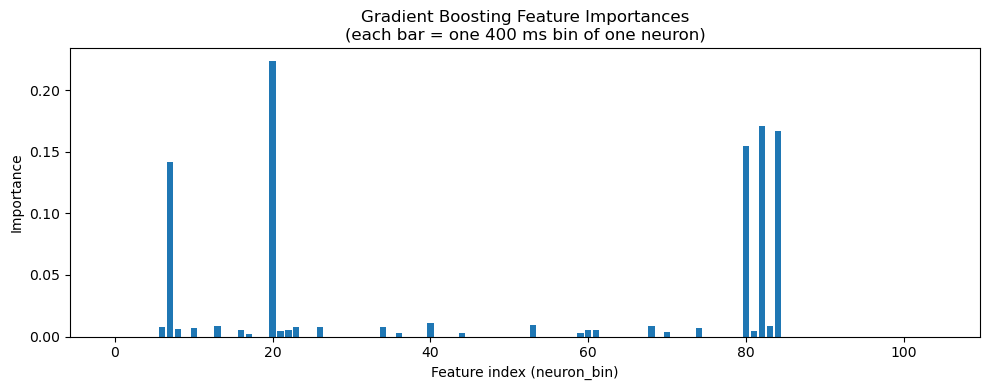

In [52]:
# ─── Chunk 8: Visualize Feature Importances ────────────────────────────────────
importances = best_model.feature_importances_

plt.figure(figsize=(10, 4))
plt.bar(range(len(importances)), importances)
plt.xlabel("Feature index (neuron_bin)")
plt.ylabel("Importance")
plt.title("Gradient Boosting Feature Importances\n(each bar = one 400 ms bin of one neuron)")
plt.tight_layout()
plt.show()
